In [1]:
import numpy as np
import gradflow.comp_graph as cg
import gradflow.dataloader as dl
import matplotlib.pyplot as plt

In [2]:
mnist_trn = dl.MNISTLoader("../datasets/MNIST", batch_size=512, split='train')
mnist_trn.load_into_memory()
mnist_trn.shuffle()

# mnist_tst = dl.MNISTLoader("./datasets/MNIST", batch_size=512, split='test')
# mnist_tst.load_into_memory()

Cloning MNIST into ../datasets/MNIST


Cloning into '../datasets/MNIST'...
Updating files: 100% (70006/70006), done.


In [3]:
X, Y = mnist_trn.get_next_batch()

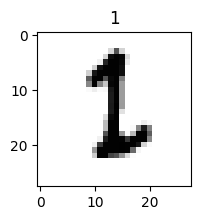

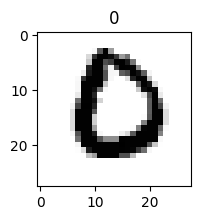

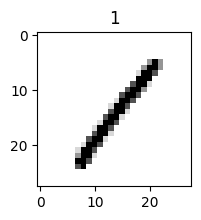

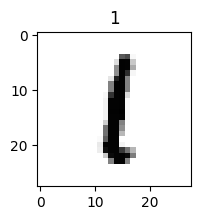

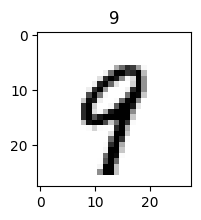

In [4]:
for x, y in zip(X[:5], Y[:5]):
    fig, axes = plt.subplots(figsize=(2,2))
    plt.imshow(x, cmap='Grays')
    plt.title(y)
    plt.show()